Dropping all-NaN columns: ['intro_rate_period', 'multifamily_affordable_units', 'co-applicant_ethnicity-5', 'denial_reason-2', 'denial_reason-3', 'denial_reason-4']
=== Original Logistic Regression ===
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2585
           1       1.00      1.00      1.00     75648

    accuracy                           0.99     78233
   macro avg       0.94      0.96      0.95     78233
weighted avg       0.99      0.99      0.99     78233

ROC-AUC: 0.997359505043414

=== Logistic Regression (Balanced) ===
              precision    recall  f1-score   support

           0       0.57      0.99      0.73      2585
           1       1.00      0.97      0.99     75648

    accuracy                           0.98     78233
   macro avg       0.79      0.98      0.86     78233
weighted avg       0.99      0.98      0.98     78233

ROC-AUC: 0.9973295843192701

Top coefficients (Original):
hoepa_status       

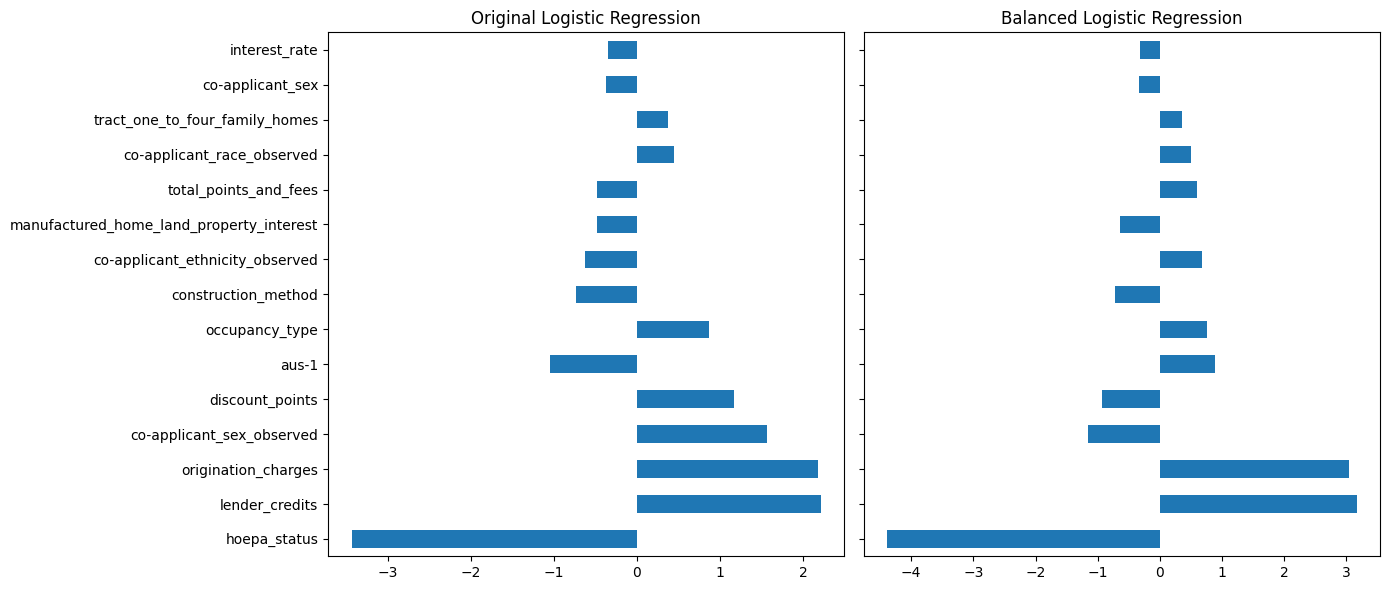

In [ ]:

import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

DATA_PROCESSED = "../data/processed"

# Load train/test data
train = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_train.csv"))
test = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_test.csv"))

# Define outcome variable 
target = "approved"

# Excluded unnecessary columns
drop_cols = ["approved", "lei", "action_taken", "state_code", "county_code", "census_tract"]

X_train = train.drop(columns=[c for c in drop_cols if c in train.columns])
y_train = train[target]

X_test = test.drop(columns=[c for c in drop_cols if c in test.columns])
y_test = test[target]

# Keep only numeric columns for regression
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Replace inf with NaN
X_train_num = X_train[num_cols].replace([np.inf, -np.inf], np.nan)
X_test_num = X_test[num_cols].replace([np.inf, -np.inf], np.nan)

# Drop all-NaN columns
nan_cols = X_train_num.columns[X_train_num.isna().all()].tolist()
if nan_cols:
    print("Dropping all-NaN columns:", nan_cols)
    X_train_num = X_train_num.drop(columns=nan_cols)
    X_test_num = X_test_num.drop(columns=nan_cols)
    num_cols = X_train_num.columns.tolist()

# Fill remaining NaNs with mediam 
imputer = SimpleImputer(strategy="median")
X_train_num = pd.DataFrame(imputer.fit_transform(X_train_num), columns=num_cols, index=X_train.index)
X_test_num = pd.DataFrame(imputer.transform(X_test_num), columns=num_cols, index=X_test.index)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

# Logistic Regression Baseline (original) 
clf = LogisticRegression(max_iter=1000, solver="liblinear")
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)[:, 1]

print("=== Original Logistic Regression ===")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# Logistic Regression with Class Weighting
clf_bal = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
clf_bal.fit(X_train_scaled, y_train)

y_pred_bal = clf_bal.predict(X_test_scaled)
y_prob_bal = clf_bal.predict_proba(X_test_scaled)[:, 1]

print("\n=== Logistic Regression (Balanced) ===")
print(classification_report(y_test, y_pred_bal))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_bal))

# Compare two models
coefs = pd.Series(clf.coef_[0], index=num_cols).sort_values(key=abs, ascending=False)
coefs_bal = pd.Series(clf_bal.coef_[0], index=num_cols).sort_values(key=abs, ascending=False)

print("\nTop coefficients (Original):")
print(coefs.head(15))

print("\nTop coefficients (Balanced):")
print(coefs_bal.head(15))

# --- Plot Coefficient Comparison ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

coefs.head(15).plot(kind="barh", ax=axes[0], title="Original Logistic Regression")
coefs_bal.head(15).plot(kind="barh", ax=axes[1], title="Balanced Logistic Regression")

plt.tight_layout()
plt.show()